# Explortatory analysis 

Notebook for exploratory analysis on tetrode data in the mPFC of a rat doing the parametric working memory (PWM) task.

Session: `data_sdc_20190902_145404_fromSD`

Current data storage:
* raw .dat, .rec, .mda, .bin and preprocessed .bin files are located on scratch under ``

* sorted data is located on bucket `Y:\jbreda\ephys\post_sort_analysis\sorted_pre_bdata`

* in a sorted folder: 
    * folder for each .bin bundle & cluster notes, matlab struct w/ spike info from scraped phy, matlab struct w/ behavior info scraped from bdata
    * in .bin bundle folder you will find curated kilosort output, mask info as npy and preprocessed .bin that was run

see [jbreda_PWM_ephys_analysis](https://github.com/Brody-Lab/jbreda_PWM_ephys_analysis) for more info on how this info was obtained


**TODO**
* plotting iterations
* save out bndl dfs as csv?
* create a dict of paths? or determine what should be passed into to bigger script



## Libs & fxs

In [1]:
# settings

%load_ext autoreload
%autoreload 2

# libraries
import sys; sys.path.insert(0, '..') # if you don't find it here, look one above
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.io as spio
import pickle
# stored one repo up in my fork of Spykes
from spykes.spykes.plot.neurovis import NeuroVis
from io_utils import *
from plotting_utils import * 

sns.set_context("talk")

## I/O & Wrangle

In [ ]:
"Helpful code for saving out"
# sess_names = np.array(['data_sdb_20190724_193007_fromSD', 'data_sdc_20190902_145404_fromSD', 'W122_07_27_2019_1_fromSD', 
#             'W122_08_06_2019_1_fromSD', 'W122_08_07_2019_1_fromSD', 'W122_08_31_2019_1_fromSD', 'W122_09_04_2019_1_fromSD',
#             'W122_09_09_2019_1_fromSD', 'W122_09_10_2019_1_fromSD', 'W122_09_11_2019_1_fromSD', 'W122_09_12_2019_1_fromSD',
#             'W122_09_19_2019_1_fromSD', 'W122_09_21_2019_1_fromSD', 'W122_09_24_2019_1_fromSD'])

#np.save('sess_names.npy', sess_names)


# # beh_df.to_csv(os.path.join(dir_name, sess_name, 'beh_df.csv'), index=False)

# # preloading spks_dict
# import pickle

# f = open(os.path.join(dir_name, sess_name, 'spks_dict.pkl'),"wb")
# pickle.dump(spks_dict,f)
# f.close()

# f= open(os.path.join(dir_name, sess_name, 'spks_dict.pkl'), "rb")
# loaded_dictionary = pickle.load(f)


In [2]:
# global
sess_names = np.load('sess_names.npy')

dir_name  = 'Y:\jbreda\ephys\post_sort_analysis\sorted_pre_bdata' 
beh_mat   = 'protocol_info.mat'
spks_mat  = 'ksphy_clusters_foranalysis.mat'
sess_name = sess_names[1]
sess_dir = os.path.join(dir_name, sess_name)

# create paths
beh_path  = os.path.join(dir_name, sess_name, beh_mat)
spks_path = os.path.join(dir_name, sess_name, spks_mat)

# load & wrangle
beh_df, spks_dict = load_and_wrangle(beh_path, spks_path, overwrite=True)

# get neurons into NeuroVis objects
neurons = initiate_neurons(spks_dict, "20190902")


C:\Users\brodylab\Documents\GitHub\jbreda_PWM_ephys_analysis\io_utils.py:253: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beh_df['hit_hist'][beh_df['hit_hist'].isnull()] = "viol"


In [3]:
beh_df

,trial_num,hit_hist,delay,pair_hist,correct_side,prev_side,aud1_sigma,aud2_sigma,c_poke,end_state,hit_state,aud1_on,aud1_off,aud2_on,aud2_off
0,1,viol,6,9,RIGHT,NaN,0.008904,0.007300,476.563229,478.330221,NaN,NaN,NaN,NaN,NaN
1,2,viol,4,4,RIGHT,RIGHT,0.053144,0.019683,479.869221,481.457220,NaN,NaN,NaN,NaN,NaN
2,3,hit,6,3,RIGHT,RIGHT,0.019683,0.007290,482.048223,491.384224,490.309221,482.098232,482.498223,488.499224,488.898223
3,4,miss,2,9,RIGHT,RIGHT,0.008904,0.007300,498.909227,504.188223,502.903229,498.960232,499.360221,501.359229,501.759230
4,5,hit,2,6,LEFT,RIGHT,0.002700,0.007290,505.471227,510.643223,509.341221,505.522228,505.922229,507.922222,508.321227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,401,hit,2,2,RIGHT,LEFT,0.007290,0.002700,5227.210220,5232.558223,5231.212228,5227.260225,5227.660226,5229.661221,5230.061221
401,402,hit,2,12,LEFT,RIGHT,0.002704,0.007300,5241.322233,5246.522218,5245.159224,5241.373230,5241.773230,5243.773224,5244.173227
402,403,hit,2,14,LEFT,LEFT,0.005985,0.007300,5251.930228,5256.937232,5255.634227,5251.980234,5252.381230,5254.381225,5254.781231
403,404,viol,6,7,LEFT,LEFT,0.007290,0.019683,5261.118223,5269.656222,NaN,NaN,NaN,NaN,NaN


In [4]:
spks_dict

{'date': '190902',
 'spk2fsm': array([  0.99994683, 130.6813586 ]),
 'fs': 30000,
 'trode_nums': [8, 10, 10, 10],
 'spk_qual': ['multi', 'multi', 'multi', 'multi'],
 'spk_times': [array([[ 630.68913607],
         [ 630.71466805],
         [ 630.73770016],
         ...,
         [5305.27491967],
         [5305.28535244],
         [5305.30828456]]),
  array([[ 630.80926302],
         [ 630.90905771],
         [ 630.91409078],
         ...,
         [5304.87194109],
         [5304.88334049],
         [5304.93253787]]),
  array([[ 630.85672716],
         [ 631.12857937],
         [ 635.01620597],
         ...,
         [5300.12316029],
         [5300.13319309],
         [5300.59860167]]),
  array([[ 630.66323745],
         [ 630.68966938],
         [ 630.72376757],
         ...,
         [5305.36471489],
         [5305.37978076],
         [5305.39241342]])],
 'mean_wav': [array([[-29.86769634, -26.33201295, -16.77566434,  -1.70596231,
           15.81754689,  31.30769942,  41.29871659,  44

## Dealing with 0ing out info

In [5]:
bndl_dfs, df_names = deal_with_masking(spks_dict, beh_df, sess_dir)

loading mask info....
mask info loaded
loading mask info....
mask info loaded


In [7]:
bndl_dfs[df_names[0]]

,trial_num,hit_hist,delay,pair_hist,correct_side,prev_side,aud1_sigma,aud2_sigma,c_poke,end_state,hit_state,aud1_on,aud1_off,aud2_on,aud2_off
15,16,viol,2,4,RIGHT,RIGHT,0.053144,0.019683,624.708223,629.272218,NaN,NaN,NaN,NaN,NaN
16,17,hit,2,2,RIGHT,RIGHT,0.007290,0.002700,629.377224,634.437228,633.148224,629.428223,629.828223,631.828220,632.228224
22,23,hit,2,1,RIGHT,RIGHT,0.002700,0.001000,684.046215,689.180224,687.884237,684.096224,684.496236,686.496224,686.896231
23,24,hit,4,8,LEFT,RIGHT,0.019683,0.053144,694.376218,701.768215,700.364220,694.426220,694.826222,698.826221,699.226219
26,27,hit,2,3,RIGHT,LEFT,0.019683,0.007290,727.344221,732.372217,731.167224,727.394224,727.794228,729.794222,730.194226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285,286,hit,4,14,LEFT,LEFT,0.005985,0.007300,3670.922223,3677.865223,3676.702220,3670.973221,3671.373221,3675.372225,3675.772226
286,287,viol,4,9,RIGHT,LEFT,0.008904,0.007300,4034.035229,4035.639229,NaN,NaN,NaN,NaN,NaN
297,298,hit,6,2,RIGHT,LEFT,0.007290,0.002700,4154.341220,4163.456219,4162.145222,4154.391221,4154.791226,4160.791224,4161.191223
299,300,viol,4,3,RIGHT,LEFT,0.019683,0.007290,4179.229225,4185.140228,NaN,NaN,NaN,NaN,NaN


In [362]:
"NEXT NEXT STEP, integrate w/ plotting functions to iteratively take dfs"

'NEXT NEXT STEP, integrate w/ plotting functions to iteratively take dfs'

# Plotting 2 second, L hit trials

In [8]:
# filter dataframe
beh_df_d2_hl = beh_df[(beh_df['correct_side'] == 'LEFT') & (beh_df['delay'] == 2)
       & (beh_df['hit_hist'] == 'hit')]

# deal with masking
bndl_dfs, df_names = deal_with_masking(spks_dict, beh_df_d2_hl, sess_dir)

# initilaize
events = ['c_poke', 'aud1_on', 'aud2_on', 'aud1_on']
windows = [[-300,700], [-500,1000], [-500, 1000], [-1000,2300]]

loading mask info....
mask info loaded
loading mask info....
mask info loaded


In [11]:
# create
neuron_rasters = get_neuron_rasters(neurons, events, windows, bndl_dfs, df_names)
neuron_psths = get_neuron_psths(neurons, events, windows, bndl_dfs, df_names)

In [ ]:
"""TODO- iteratvely plot final plot(raster, psth, avg wav) for all 4 nuerons in all 4 conditions & save out"""
"""TODO- then, put into .py scrip, adjust top inputs, and run on good days from august"""

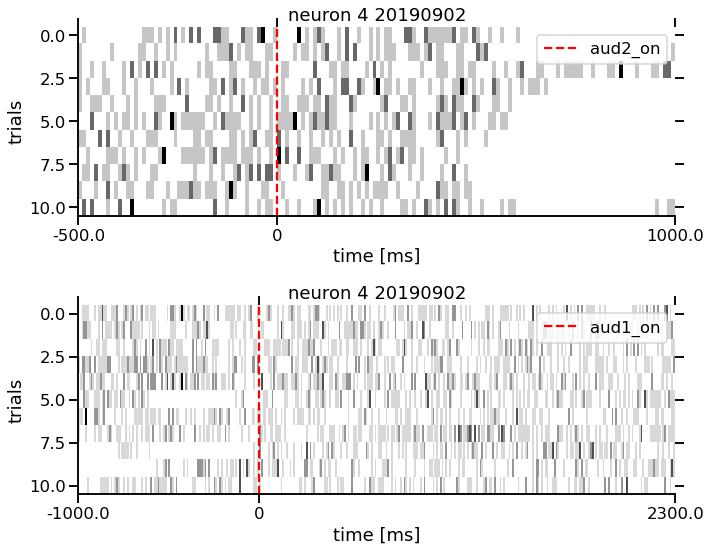

In [12]:
fig, ax = plt.subplots(2,1, figsize = (10,8))
nn = 3
cc = 2
neurons[nn].plot_raster(neuron_rasters[nn][cc], axis = ax[0], event_name=events[cc], cmap="Greys")
neurons[nn].plot_raster(neuron_rasters[nn][cc+1], axis = ax[1], event_name=events[cc+1], cmap="Greys")

# neurons[nn].plot_psth(neuron_psths[nn][cc],axis=ax[1], event_name=events[cc])

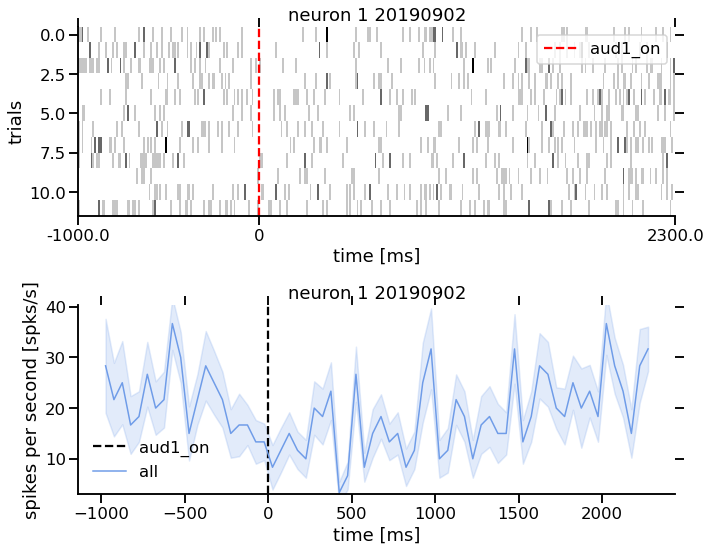

In [13]:
fig, ax = plt.subplots(2,1, figsize = (10,8))
nn = 0
cc = 3

neurons[nn].plot_raster(neuron_rasters[nn][cc], axis = ax[0], event_name=events[cc], cmap="Greys")
neurons[nn].plot_psth(neuron_psths[nn][cc],axis=ax[1], event_name=events[cc])

## Rogue plots

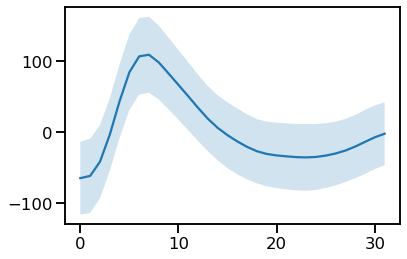

In [25]:
nn = 0
tt = 1
mean_wave = spks_dict['mean_wav'][nn][tt].T
std = spks_dict['std_wave'][nn][tt].T
plt.plot(mean_wave)
plt.fill_between(np.arange(len(std)), mean_wave + std, mean_wave - std, alpha = 0.2)

In [24]:
spks_dict['std_wave'][1][0].

(32,)

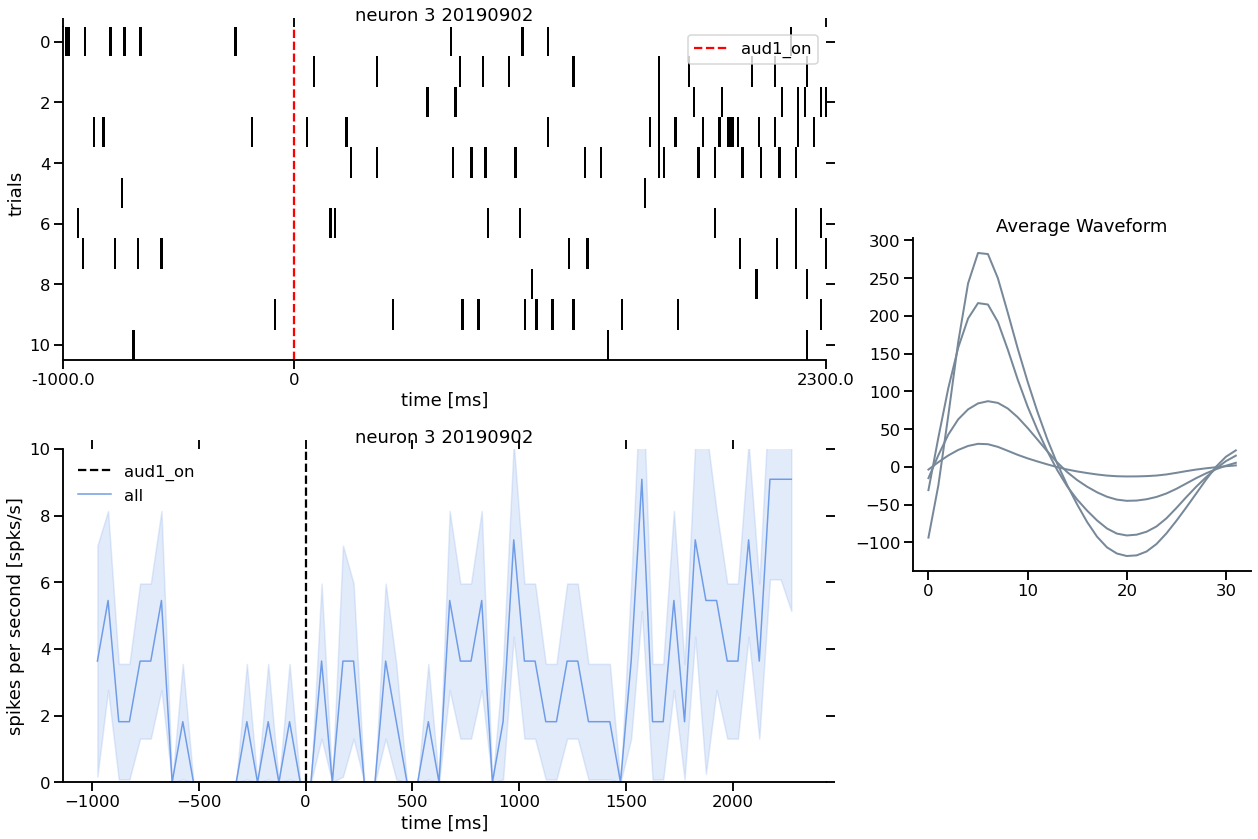

In [30]:
sns.set_context("talk")
fig = plt.figure(figsize=(18,12))
ax1 = plt.subplot2grid((4, 3), (0, 0), rowspan=2, colspan=2) 
ax2 = plt.subplot2grid((4, 3), (2, 0), rowspan=2, colspan=2)
ax3 = plt.subplot2grid((4, 3), (1, 2), rowspan=2, colspan=1)


nn = 2
cc = 3

mean_wav = spks_dict['mean_wav'][nn]


neurons[nn].plot_raster(neuron_rasters[nn][cc], axis = ax1, event_name=events[cc], cmap="Greys")
neurons[nn].plot_psth(neuron_psths[nn][cc],axis=ax2, event_name=events[cc])
for i in range(4):
    ax3.plot(mean_wav[i],color = 'lightslategrey',lw=2)
    
ax3.set_title('Average Waveform')

save_name=neurons[0].name
fig.savefig('neuron1.jpeg')
